# Approche hybride avec LightFM

## Donn√©es

### Chargement du dataframe global

In [1]:
import pandas as pd

df_clicks = pd.read_parquet("./data/df_final.parquet")
print("‚úÖ Dataset recharg√© avec succ√®s.")

‚úÖ Dataset recharg√© avec succ√®s.


In [2]:
df_clicks.head()

user_id        session_id  session_start  session_size  click_article_id  \
0        0  1506825423271737  1506825423000             2            157541   
1        0  1506825423271737  1506825423000             2             68866   
2        1  1506825426267738  1506825426000             2            235840   
3        1  1506825426267738  1506825426000             2             96663   
4        2  1506825435299739  1506825435000             2            119592   

   click_timestamp click_environment click_deviceGroup click_os click_country  \
0    1506826828020                 4                 3       20             1   
1    1506826858020                 4                 3       20             1   
2    1506827017951                 4                 1       17             1   
3    1506827047951                 4                 1       17             1   
4    1506827090575                 4                 1       17             1   

   ...        31        32        33        34        35        36        37  \
0  ... -0.321484  0.910162 -0.413011  0.680835 -0.418409 -0.526443  0.305625   
1  ... -1.001013  0.797471 -0.492230 -0.305857 -1.307835  0.354010  0.696917   
2  ... -0.269690  0.873445  0.194144  0.056367 -0.431036 -0.020383 -0.376942   
3  ...  0.144034 -2.457183 -1.500929 -1.807169 -0.208940 -0.671638 -0.407914   
4  ... -1.163678 -0.230112 -2.132536 -0.729996  0.581913 -0.559910 -0.354824   

         38        39        40  
0 -0.307805 -0.606366 -0.650556  
1 -0.486316  0.017210 -1.563045  
2  0.814494  0.709722 -1.030146  
3  2.561696 -1.379031 -1.877568  
4 -0.914158 -0.064399 -0.354175  

[5 rows x 66 columns]

## Matrice utilisateur-item

| Situation | Strat√©gie sur la matrice user-item | Raison |
|----------|-------------------------------------|--------|
| **Collaborative pur** (pas de features) | üî• Maximiser l'intensit√© : `alpha` √©lev√©, `weighting='log'`, **pas de normalisation** | Cela amplifie les diff√©rences de pr√©f√©rence et donne du signal fort √† LightFM |
| **Hybride (avec user/item features)** | ‚öñÔ∏è Normalisation coh√©rente des valeurs dans `[0, 1]` sur **toutes les matrices** (y compris interactions) | Cela √©vite que les features soient √©cras√©es ou n√©glig√©es par un d√©s√©quilibre d‚Äô√©chelle | 

<br>
C'est le principe de <b>l'√©quilibrage des signaux dans les syst√®mes hybrides de recommandation</b>. Si on normalise seulement les features mais la matrice user-item reste avec des valeurs hautes les features seront ign√©es par le le mod√®le. Si on normalise tout il faut √©viter d'√©craser la variance <br>

üõ†Ô∏è Bonnes pratiques √† appliquer<br>
| √âl√©ment | Bonne √©chelle |
|--------|----------------|
| `user_features` | `[0, 1]` (via MinMax ou OneHot) |
| `item_features` | `[0, 1]` (MinMax + embeddings d√©j√† compress√©s) |
| `interaction_matrix` | `[0, 1]` uniquement si features aussi pr√©sentes (sinon garder amplitudes fortes) |

In [3]:
from scipy.sparse import coo_matrix
from tqdm import tqdm
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def build_user_item_matrix_for_lightfm(df_clicks, weighting="log", alpha=40.0, normalize=False):
    """
    Construit une matrice CSR (utilisateurs √ó articles) pour LightFM avec pond√©ration et normalisation optionnelles.

    Param√®tres :
    - df_clicks : DataFrame avec 'user_id' et 'click_article_id'
    - weighting : 'log' ou 'linear'
    - alpha : pond√©ration log
    - normalize : False, 'minmax', 'standard', 'log', 'user_minmax', 'user_standard', ou fonction custom

    Retourne :
    - user_item_matrix : matrice CSR
    - user_mapping : dict {user_id ‚Üí index}
    - item_mapping : dict {click_article_id ‚Üí index}
    """
    # Agr√©gation des clics
    df_user_item = (
        df_clicks.groupby(['user_id', 'click_article_id'])
        .size()
        .reset_index(name='click_strength')
    )

    # Mappings
    print("üîÑ Construction des dictionnaires d‚Äôindexation...")
    user_ids = df_user_item['user_id'].unique()
    item_ids = df_user_item['click_article_id'].unique()

    user_mapping = {uid: idx for idx, uid in enumerate(tqdm(user_ids, desc="üî¢ Mapping users"))}
    item_mapping = {iid: idx for idx, iid in enumerate(tqdm(item_ids, desc="üßæ Mapping articles"))}

    df_user_item['user_idx'] = df_user_item['user_id'].map(user_mapping)
    df_user_item['item_idx'] = df_user_item['click_article_id'].map(item_mapping)

    # Pond√©ration
    if weighting == "log":
        df_user_item['weight'] = 1.0 + alpha * np.log1p(df_user_item['click_strength'])
        print(f"üßÆ Pond√©ration logarithmique avec alpha={alpha}")
    elif weighting == "linear":
        df_user_item['weight'] = df_user_item['click_strength'].astype(float)
        print("üßÆ Pond√©ration lin√©aire")
    else:
        raise ValueError("Le param√®tre 'weighting' doit √™tre 'log' ou 'linear'.")

    # Normalisation
    if normalize:
        print(f"üìè Normalisation des poids : {normalize}")
        if normalize == 'minmax':
            scaler = MinMaxScaler()
            df_user_item['weight'] = scaler.fit_transform(df_user_item[['weight']])
        elif normalize == 'standard':
            scaler = StandardScaler()
            df_user_item['weight'] = scaler.fit_transform(df_user_item[['weight']])
        elif normalize == 'log':
            df_user_item['weight'] = np.log1p(df_user_item['weight'])
        elif normalize == 'user_minmax':
            df_user_item['weight'] = df_user_item.groupby('user_idx')['weight'].transform(
                lambda x: MinMaxScaler().fit_transform(x.values.reshape(-1, 1)).flatten()
            )
        elif normalize == 'user_standard':
            df_user_item['weight'] = df_user_item.groupby('user_idx')['weight'].transform(
                lambda x: StandardScaler().fit_transform(x.values.reshape(-1, 1)).flatten()
            )
        elif callable(normalize):
            df_user_item['weight'] = normalize(df_user_item['weight'].values)
        else:
            raise ValueError("Le param√®tre 'normalize' doit √™tre False, 'minmax', 'standard', 'log', "
                             "'user_minmax', 'user_standard' ou une fonction.")

    # Matrice sparse
    print("üìê Construction de la matrice sparse (CSR)...")
    user_item_matrix = coo_matrix(
        (df_user_item['weight'],
         (df_user_item['user_idx'], df_user_item['item_idx']))
    ).tocsr()

    print(f"‚úÖ Matrice pr√™te : {user_item_matrix.shape} (utilisateurs √ó articles)")
    return user_item_matrix, user_mapping, item_mapping


In [4]:
# Cr√©ation de la matrice et des mappages d'index
# # Pas de normalisation (collaborative pur)
# build_user_item_matrix_for_lightfm(df_clicks, normalize=False)
# # Hybride avec normalisation MinMax
# build_user_item_matrix_for_lightfm(df_clicks, normalize='minmax')
# # Hybride avec log compression
# build_user_item_matrix_for_lightfm(df_clicks, normalize='log')

user_item_matrix, user_mapping, item_mapping = build_user_item_matrix_for_lightfm(df_clicks, normalize=False)

üîÑ Construction des dictionnaires d‚Äôindexation...


üßæ Mapping articles: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 46033/46033 [00:00<00:00, 4783973.74it/s]


üßÆ Pond√©ration logarithmique avec alpha=40.0
üìê Construction de la matrice sparse (CSR)...
‚úÖ Matrice pr√™te : (322897, 46033) (utilisateurs √ó articles)


<div style="padding: 10px; border-radius: 5px; background-color: #e7f3fe; color: #31708f; border-left: 6px solid #2196F3;">
‚ÑπÔ∏è <strong>Note :</strong> Contrairement √† Implicit on ne filtre pas les utilisateurs ayant moins de 3 interactions afin de ne pas occulter la situation correspond √† beaucoup de cas: utilisateur peu actif. Les m√©triques seront sans doute moins bonnes qu'avec un filtrage
</div>

## Split LOO

In [5]:
import numpy as np
from scipy.sparse import csr_matrix, lil_matrix

def leave_one_out_split(interactions):
    """
    R√©alise un split Leave-One-Out sur une matrice utilisateurs √ó articles.
    
    Param√®tres :
    - interactions : csr_matrix (n_users x n_items)

    Retourne :
    - train : csr_matrix (interactions moins 1 par utilisateur)
    - test : csr_matrix (1 interaction par utilisateur)
    """
    assert isinstance(interactions, csr_matrix), "La matrice d'entr√©e doit √™tre au format CSR."

    print("üîÑ Split Leave-One-Out en cours...")

    interactions = interactions.tolil()  # Acc√®s rapide ligne par ligne
    n_users, n_items = interactions.shape

    train = lil_matrix(interactions.shape, dtype=np.float32)
    test = lil_matrix(interactions.shape, dtype=np.float32)

    rng = np.random.default_rng(seed=42)  # Pour reproductibilit√©

    for user_id in range(n_users):
        user_interactions = interactions.rows[user_id]
        user_data = interactions.data[user_id]

        if len(user_interactions) >= 2:
            idx = rng.integers(0, len(user_interactions))

            test_item = user_interactions[idx]
            test_value = user_data[idx]

            # Ajouter au test
            test[user_id, test_item] = test_value

            # Ajouter le reste au train
            for i, item in enumerate(user_interactions):
                if i != idx:
                    train[user_id, item] = user_data[i]
        else:
            for i, item in enumerate(user_interactions):
                train[user_id, item] = user_data[i]

    print(f"‚úÖ Split termin√© :\n - Train shape : {train.shape}\n - Test shape : {test.shape}")
    return train.tocsr(), test.tocsr()


In [6]:
# Jeux de train et test
train_matrix, test_matrix = leave_one_out_split(user_item_matrix)

üîÑ Split Leave-One-Out en cours...
‚úÖ Split termin√© :
 - Train shape : (322897, 46033)
 - Test shape : (322897, 46033)


<div style="padding: 10px; border-radius: 5px; background-color: #e7f3fe; color: #31708f; border-left: 6px solid #2196F3;">
‚ÑπÔ∏è <strong>‚ú® Fonctionnement :</strong> tolil() ‚ûî convertit temporairement en LIL (list of lists). C'est une structure de matrice creuse qui stocke pour chaque ligne une liste de colonnes non-nulles, une autre list associ√©e qui contient les valeurs de ces colonnes. Donc par ligne on garde: un tableau des indices de colonnes non nulles, un tableau des valeurs correspondantes. Format adapt√© pour construire, CSR est meilleur pour les calculs (matmul) et la mise en oeuvre du mod√®le
</div>

## M√©triques

### M√©triques de recommantion

üëâ NDCG@k (Normalized Discounted Cumulative Gain) doit √™tre calcul√© √† la main car LightFM ne le donne pas directement.

In [7]:
from tqdm.notebook import tqdm
import numpy as np
from joblib import Parallel, delayed

def ndcg_at_k(model, test_interactions, train_interactions=None, 
              user_features=None, item_features=None, 
              k=5, num_threads=8):
    """
    Calcule le NDCG@k utilisateur par utilisateur (vectoris√© + parall√©lis√©).
    """
    n_users, n_items = test_interactions.shape
    test_csr = test_interactions.tocsr()
    train_csr = train_interactions.tocsr() if train_interactions is not None else None

    def compute_ndcg(user_id):
        true_items = test_csr[user_id].indices
        if len(true_items) == 0:
            return None

        scores = np.array(model.predict(
            user_id,
            np.arange(n_items),
            user_features=user_features,
            item_features=item_features,
            num_threads=1
        )).copy() # rend l'array modifiable

        # Masquer les items vus pendant le training
        if train_csr is not None:
            train_items = train_csr[user_id].indices
            scores[train_items] = -np.inf

        top_k_items = np.argpartition(-scores, k)[:k]
        top_k_items = top_k_items[np.argsort(-scores[top_k_items])]  # tri final

        relevances = np.isin(top_k_items, true_items).astype(int)
        dcg = np.sum(relevances / np.log2(np.arange(2, k + 2)))
        idcg = np.sum(1.0 / np.log2(np.arange(2, min(len(true_items), k) + 2)))

        return dcg / idcg if idcg > 0 else 0.0

    results = Parallel(n_jobs=num_threads, backend="threading")(
        delayed(compute_ndcg)(user_id)
        for user_id in tqdm(range(n_users), total=n_users, desc="Calcul NDCG@k (parall√®le)")
    )

    results = [r for r in results if r is not None]  # supprimer les utilisateurs sans clics
    return np.mean(results) if results else 0.0


### Erreurs RMSE et MAE

üìö Note: LightFM est principalement con√ßu pour optimiser du ranking (ordre des items) et travailler sur des interactions implicites (clic, vue, achat = 1 ou pas = 0).<br>
RMSE (Root Mean Squared Error) et MAE (Mean Absolute Error) sont normalement utilis√©s sur :<br>
- des valeurs continues (ex : pr√©diction d'une note sur 5).
- des mod√®les de pr√©diction de score explicite (comme SVD dans Surprise).
  
<br>
üëâ Or LightFM peut quand m√™me pr√©dire un score implicite (predict(user, item)) continu. Ce sont des scores relatifs, pas des probabilit√©s calibr√©es. <br>
üëâ Donc on peut comparer ces scores aux clics r√©els (1 s'il a cliqu√©, 0 sinon). On a bien une proximit√© entre le score pr√©dit et le clic r√©el.<br>
<b>M√©triques donn√©es pour information, elles ne constituent pas un crit√®re pour LightFM </b>

In [8]:
from tqdm.notebook import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
from joblib import Parallel, delayed

def compute_rmse_mae(model, test_interactions, train_interactions=None,
                     user_features=None, item_features=None,
                     num_threads=8):
    """
    Calcule RMSE et MAE pour un mod√®le LightFM (multithread√© et s√©curis√©).
    """
    n_users, n_items = test_interactions.shape
    test_csr = test_interactions.tocsr()
    train_csr = train_interactions.tocsr() if train_interactions is not None else None

    def compute_user_predictions(user_id):
        true_items = test_csr[user_id].indices
        if len(true_items) == 0:
            return [], []

        scores = np.array(model.predict(
            user_id,
            np.arange(n_items),
            user_features=user_features,
            item_features=item_features,
            num_threads=1  # s√©curis√© pour joblib threading
        )).copy()  # √©vite le buffer read-only

        if train_csr is not None:
            train_items = train_csr[user_id].indices
            scores[train_items] = -np.inf

        y_t = [1] * len(true_items)
        y_p = [scores[item] for item in true_items]

        return y_t, y_p

    results = Parallel(n_jobs=num_threads, backend="threading")(
        delayed(compute_user_predictions)(user_id)
        for user_id in tqdm(range(n_users), total=n_users, desc="Calcul RMSE/MAE (parall√®le)")
    )

    # Fusion des r√©sultats
    y_true, y_pred = [], []
    for y_t, y_p in results:
        y_true.extend(y_t)
        y_pred.extend(y_p)

    if not y_true:
        raise ValueError("Aucune interaction √† √©valuer.")

    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)

    return rmse, mae


## Entrainement (baseline: matrice user-item)

In [9]:
from lightfm import LightFM
from lightfm.evaluation import precision_at_k, recall_at_k
from itertools import product
from tqdm.notebook import tqdm

def grid_search_lightfm(train_matrix, test_matrix,
                        user_features=None, item_features=None,
                        k=5, num_threads=4, max_epochs=30,
                        eval_metric="precision",
                        eval_every=5, patience=3):
    """
    Grid search avec early stopping LightFM (hybride-compatible).

    Nouveaux param√®tres :
    - eval_every : fr√©quence d‚Äô√©valuation (en epochs)
    - patience : nombre d‚Äô√©valuations sans am√©lioration avant arr√™t
    - max_epochs : nombre d‚Äôepochs max
    """
    from lightfm import LightFM
    from lightfm.evaluation import precision_at_k, recall_at_k
    from itertools import product
    from joblib import Parallel, delayed
    import numpy as np

    # Import ndcg_at_k personnalis√© si n√©cessaire
    def ndcg_at_k(model, test_interactions, train_interactions=None, 
                  user_features=None, item_features=None, 
                  k=5, num_threads=8):
        n_users, n_items = test_interactions.shape
        test_csr = test_interactions.tocsr()
        train_csr = train_interactions.tocsr() if train_interactions is not None else None

        def compute_ndcg(user_id):
            true_items = test_csr[user_id].indices
            if len(true_items) == 0:
                return None
            scores = model.predict(
                user_id,
                np.arange(n_items),
                user_features=user_features,
                item_features=item_features,
                num_threads=1
            ).copy()
            if train_csr is not None:
                train_items = train_csr[user_id].indices
                scores[train_items] = -np.inf
            top_k_items = np.argpartition(-scores, k)[:k]
            top_k_items = top_k_items[np.argsort(-scores[top_k_items])]
            relevances = np.isin(top_k_items, true_items).astype(int)
            dcg = np.sum(relevances / np.log2(np.arange(2, k + 2)))
            idcg = np.sum(1.0 / np.log2(np.arange(2, min(len(true_items), k) + 2)))
            return dcg / idcg if idcg > 0 else 0.0

        results = Parallel(n_jobs=num_threads, backend="threading")(
            delayed(compute_ndcg)(user_id)
            for user_id in range(n_users)
        )
        results = [r for r in results if r is not None]
        return np.mean(results) if results else 0.0

    # Grille de recherche
    param_grid = {
        'loss': ['warp', 'bpr'],
        'no_components': [32, 64],
        'learning_rate': [0.01, 0.05, 0.1]
    }

    best_score = 0.0
    best_model = None
    best_params = None

    all_combinations = list(product(
        param_grid['loss'],
        param_grid['no_components'],
        param_grid['learning_rate']
    ))

    print(f"üîç Recherche sur {len(all_combinations)} combinaisons...")

    for loss, no_components, learning_rate in all_combinations:
        print(f"\nüöÄ Entra√Ænement mod√®le : loss={loss}, components={no_components}, lr={learning_rate}")
        model = LightFM(
            loss=loss,
            no_components=no_components,
            learning_rate=learning_rate,
            random_state=42
        )

        best_local_score = -np.inf
        no_improve_count = 0

        for epoch in range(1, max_epochs + 1):
            model.fit_partial(
                train_matrix,
                user_features=user_features,
                item_features=item_features,
                epochs=1,
                num_threads=num_threads
            )

            if epoch % eval_every == 0:
                # √âvaluer
                if eval_metric == "precision":
                    score = precision_at_k(
                        model,
                        test_matrix,
                        train_interactions=train_matrix,
                        k=k,
                        num_threads=num_threads,
                        user_features=user_features,
                        item_features=item_features
                    ).mean()
                elif eval_metric == "recall":
                    score = recall_at_k(
                        model,
                        test_matrix,
                        train_interactions=train_matrix,
                        k=k,
                        num_threads=num_threads,
                        user_features=user_features,
                        item_features=item_features
                    ).mean()
                elif eval_metric == "ndcg":
                    score = ndcg_at_k(
                        model,
                        test_matrix,
                        train_interactions=train_matrix,
                        user_features=user_features,
                        item_features=item_features,
                        k=k,
                        num_threads=num_threads
                    )
                else:
                    raise ValueError("Metric invalide")

                print(f"üìâ Epoch {epoch} ‚Äî {eval_metric}@{k} = {score:.4f}")

                if score > best_local_score:
                    best_local_score = score
                    best_model = model
                    best_params = {
                        'loss': loss,
                        'no_components': no_components,
                        'learning_rate': learning_rate,
                        'epoch': epoch
                    }
                    no_improve_count = 0
                else:
                    no_improve_count += 1
                    if no_improve_count >= patience:
                        print(f"üõë Early stopping √† l‚Äôepoch {epoch} (aucune am√©lioration depuis {patience} √©valuations)")
                        break

    print("\n‚úÖ Grid search termin√© !")
    print(f"üèÜ Meilleur mod√®le : {best_params} avec {eval_metric}@{k} = {best_local_score:.4f}")
    return best_model, best_params, best_local_score


In [10]:
best_model, best_params, best_score = grid_search_lightfm(
    train_matrix,
    test_matrix,
    user_features=None,
    item_features=None,
    k=5,
    max_epochs=30,
    eval_metric="ndcg",
    eval_every=5,
    patience=3
)

üîç Recherche sur 12 combinaisons...

üöÄ Entra√Ænement mod√®le : loss=warp, components=32, lr=0.01
üìâ Epoch 5 ‚Äî ndcg@5 = 0.0370
üìâ Epoch 10 ‚Äî ndcg@5 = 0.0376
üìâ Epoch 15 ‚Äî ndcg@5 = 0.0392
üìâ Epoch 20 ‚Äî ndcg@5 = 0.0401
üìâ Epoch 25 ‚Äî ndcg@5 = 0.0415
üìâ Epoch 30 ‚Äî ndcg@5 = 0.0424

üöÄ Entra√Ænement mod√®le : loss=warp, components=32, lr=0.05
üìâ Epoch 5 ‚Äî ndcg@5 = 0.0506
üìâ Epoch 10 ‚Äî ndcg@5 = 0.0605
üìâ Epoch 15 ‚Äî ndcg@5 = 0.0676
üìâ Epoch 20 ‚Äî ndcg@5 = 0.0732
üìâ Epoch 25 ‚Äî ndcg@5 = 0.0781
üìâ Epoch 30 ‚Äî ndcg@5 = 0.0822

üöÄ Entra√Ænement mod√®le : loss=warp, components=32, lr=0.1
üìâ Epoch 5 ‚Äî ndcg@5 = 0.0418
üìâ Epoch 10 ‚Äî ndcg@5 = 0.0501
üìâ Epoch 15 ‚Äî ndcg@5 = 0.0559
üìâ Epoch 20 ‚Äî ndcg@5 = 0.0612
üìâ Epoch 25 ‚Äî ndcg@5 = 0.0653
üìâ Epoch 30 ‚Äî ndcg@5 = 0.0686

üöÄ Entra√Ænement mod√®le : loss=warp, components=64, lr=0.01
üìâ Epoch 5 ‚Äî ndcg@5 = 0.0382
üìâ Epoch 10 ‚Äî ndcg@5 = 0.0390
üìâ Epoch 15 ‚Äî ndcg@5 = 0.04

In [11]:
# Provisoire (pour ne pas avoir √† refaire la mise au point)
best_params = {'loss': 'bpr', 'no_components': 32, 'learning_rate': 0.05}

### R√©-entrainement du meilleur mod√®le

In [12]:
import os
import pandas as pd
from lightfm import LightFM
from lightfm.evaluation import precision_at_k, recall_at_k
from tqdm.notebook import tqdm

#### üéØ Entrainement avec les param√®tres optimaux

In [13]:
def train_lightfm_model(train_matrix, best_params, user_features=None, item_features=None, epochs=50, num_threads=8):
    model = LightFM(
        loss=best_params['loss'],
        no_components=best_params['no_components'],
        learning_rate=best_params['learning_rate'],
        random_state=42
    )
    for epoch in tqdm(range(epochs), desc="Entra√Ænement LightFM"):
        model.fit_partial(
            train_matrix,
            user_features=user_features,
            item_features=item_features,
            epochs=1,
            num_threads=num_threads
        )
    return model


#### üéØ Evaluation

In [14]:
import numpy as np
import os
import pandas as pd
from scipy.sparse import csr_matrix
from lightfm.evaluation import precision_at_k, recall_at_k

def evaluate_lightfm_model(model, train_matrix, test_matrix,
                           user_features=None, item_features=None,
                           k=5, num_threads=8,
                           experiment_name="user-item",
                           results_file="results/experiments_lightfm.csv"):
    """
    √âvalue un mod√®le LightFM sur l'ensemble des utilisateurs,
    avec ou sans user/item features. Enregistre les r√©sultats dans un fichier CSV.
    """

    # Matrices d'interactions
    test_subset = test_matrix
    train_subset = train_matrix
    user_features_subset = user_features
    item_features_subset = item_features

    # üéØ Top-K m√©triques int√©gr√©es
    hit = precision_at_k(model, test_subset, train_interactions=train_subset,
                         user_features=user_features_subset,
                         item_features=item_features_subset,
                         k=k, num_threads=num_threads).mean()

    recall = recall_at_k(model, test_subset, train_interactions=train_subset,
                         user_features=user_features_subset,
                         item_features=item_features_subset,
                         k=k, num_threads=num_threads).mean()

    # üìà NDCG custom
    print("Shape pass√©e √† ndcg_at_k:", test_subset.shape)
    ndcg = ndcg_at_k(model, test_subset, train_interactions=train_subset,
                     user_features=user_features_subset,
                     item_features=item_features_subset,
                     k=k, num_threads=num_threads)

    # üìâ RMSE / MAE custom
    rmse, mae = compute_rmse_mae(model, test_subset, train_interactions=train_subset,
                                 user_features=user_features_subset,
                                 item_features=item_features_subset,
                                 num_threads=num_threads)

    # üìã R√©sultats
    new_result = {
        'Experiment': experiment_name,
        'Hit@5': hit,
        'Recall@5': recall,
        'NDCG@5': ndcg,
        'RMSE': rmse,
        'MAE': mae
    }

    # üíæ Sauvegarde CSV
    os.makedirs(os.path.dirname(results_file), exist_ok=True)
    if os.path.exists(results_file):
        results_df = pd.read_csv(results_file)
        results_df = pd.concat([results_df, pd.DataFrame([new_result])], ignore_index=True)
    else:
        results_df = pd.DataFrame([new_result])
    results_df.to_csv(results_file, index=False)
    print(f"üìÑ R√©sultats mis √† jour dans {results_file}")

    return new_result


#### üéØ R√©sultat avec matrice utilisateur-item

In [15]:
model = train_lightfm_model(train_matrix, best_params, epochs=50)

Entra√Ænement LightFM:   0%|          | 0/50 [00:00<?, ?it/s]

In [16]:
results = evaluate_lightfm_model(model, train_matrix, test_matrix,
                                 user_features=None, item_features=None)
print(results)

Shape pass√©e √† ndcg_at_k: (322897, 46033)


Calcul NDCG@k (parall√®le):   0%|          | 0/322897 [00:00<?, ?it/s]

Calcul RMSE/MAE (parall√®le):   0%|          | 0/322897 [00:00<?, ?it/s]

üìÑ R√©sultats mis √† jour dans results/experiments_lightfm.csv
{'Experiment': 'user-item', 'Hit@5': 0.036471065, 'Recall@5': 0.1823553640944326, 'NDCG@5': 0.12933830583505998, 'RMSE': 2.4708568812487504, 'MAE': 1.9329606758841589}


‚úÖ R√©sum√© du setup : <br>
- ‚öôÔ∏è Mod√®le : LightFM (avec ou sans features)
- üìä M√©triques :
    - precision_at_k, recall_at_k (LightFM natif)
    - ndcg_at_k, rmse, mae (custom, full Numpy + Joblib, optimis√©)
- üîÅ √âvaluation compl√®te sur tout le dataset
- ‚ö° Temps total d‚Äô√©valuation : ‚âà 10 minutes
- üíæ R√©sultats logg√©s proprement dans un fichier CSV

## Recalcul de la matrice d'interactions pour l'hybride

In [17]:
user_item_matrix_hybrid, user_mapping, item_mapping = build_user_item_matrix_for_lightfm(
    df_clicks, weighting="log", alpha=40.0, normalize="user_minmax"
)
train_matrix_hybrid, test_matrix_hybrid = leave_one_out_split(user_item_matrix_hybrid)


üîÑ Construction des dictionnaires d‚Äôindexation...


üî¢ Mapping users:   0%|          | 0/322897 [00:00<?, ?it/s]

üßæ Mapping articles:   0%|          | 0/46033 [00:00<?, ?it/s]

üßÆ Pond√©ration logarithmique avec alpha=40.0
üìè Normalisation des poids : user_minmax
üìê Construction de la matrice sparse (CSR)...
‚úÖ Matrice pr√™te : (322897, 46033) (utilisateurs √ó articles)
üîÑ Split Leave-One-Out en cours...
‚úÖ Split termin√© :
 - Train shape : (322897, 46033)
 - Test shape : (322897, 46033)


In [18]:
model_hybrid = train_lightfm_model(train_matrix_hybrid, best_params, epochs=50)

Entra√Ænement LightFM:   0%|          | 0/50 [00:00<?, ?it/s]

In [19]:
results = evaluate_lightfm_model(model_hybrid, train_matrix_hybrid, test_matrix_hybrid,
                                 experiment_name='user-minmax_item',
                                 user_features=None, item_features=None)
print(results)

Shape pass√©e √† ndcg_at_k: (322897, 46033)


Calcul NDCG@k (parall√®le):   0%|          | 0/322897 [00:00<?, ?it/s]

Calcul RMSE/MAE (parall√®le):   0%|          | 0/322897 [00:00<?, ?it/s]

üìÑ R√©sultats mis √† jour dans results/experiments_lightfm.csv
{'Experiment': 'user-minmax_item', 'Hit@5': 0.00837156, 'Recall@5': 0.041857798165137614, 'NDCG@5': 0.031408007649022615, 'RMSE': 2.0178207146021774, 'MAE': 1.5538137379165575}


## Calcul de la matrice de features utilisateur - features engineering
On calcule feature par feature en adaptant la normalisation

#### üöÄ 1 : Nombre de sessions par utilisateur

In [20]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def extract_number_of_sessions(df_clicks):
    """
    Extrait et normalise le nombre de sessions par utilisateur (lissage log1p + MinMax).
    
    Retourne :
    - DataFrame avec colonnes ['user_id', 'num_sessions_scaled']
    """
    sessions_per_user = df_clicks.groupby('user_id')['session_id'].nunique().reset_index()
    sessions_per_user.columns = ['user_id', 'num_sessions']
    
    # Log transform pour lisser
    sessions_per_user['num_sessions_log'] = np.log1p(sessions_per_user['num_sessions'])

    # MinMax scaling
    scaler = MinMaxScaler()
    sessions_per_user['num_sessions_scaled'] = scaler.fit_transform(
        sessions_per_user[['num_sessions_log']]
    )

    return sessions_per_user[['user_id', 'num_sessions_scaled']]


In [21]:
sessions_per_user = extract_number_of_sessions(df_clicks)
print(sessions_per_user.head())

   user_id  num_sessions_scaled
0        0             0.197290
1        1             0.269737
2        2             0.087302
3        3             0.269737
4        4             0.149244


#### üöÄ 2 : Nombre total de clics par utilisateur

In [22]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def extract_number_of_clicks(df_clicks):
    """
    Extrait et normalise le nombre total de clics par utilisateur (log1p + MinMax).

    Retourne :
    - DataFrame avec colonnes ['user_id', 'num_clicks_scaled']
    """
    clicks_per_user = df_clicks.groupby('user_id').size().reset_index(name='num_clicks')

    # Log transform
    clicks_per_user['num_clicks_log'] = np.log1p(clicks_per_user['num_clicks'])

    # MinMax scaling
    scaler = MinMaxScaler()
    clicks_per_user['num_clicks_scaled'] = scaler.fit_transform(
        clicks_per_user[['num_clicks_log']]
    )

    return clicks_per_user[['user_id', 'num_clicks_scaled']]


In [23]:
clicks_per_user = extract_number_of_clicks(df_clicks)
print(clicks_per_user.head())

   user_id  num_clicks_scaled
0        0           0.182536
1        1           0.243635
2        2           0.084875
3        3           0.297704
4        4           0.162967


#### üöÄ 3 : Nombre d'articles distincts cliqu√©s par utilisateur

In [24]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def extract_number_of_distinct_articles(df_clicks):
    """
    Extrait et normalise le nombre d'articles distincts cliqu√©s par utilisateur (log1p + MinMax).

    Retourne :
    - DataFrame avec colonnes ['user_id', 'num_distinct_articles_scaled']
    """
    distinct_articles_per_user = df_clicks.groupby('user_id')['click_article_id'].nunique().reset_index()
    distinct_articles_per_user.columns = ['user_id', 'num_distinct_articles']

    # Log transform
    distinct_articles_per_user['num_distinct_articles_log'] = np.log1p(distinct_articles_per_user['num_distinct_articles'])

    # MinMax scaling
    scaler = MinMaxScaler()
    distinct_articles_per_user['num_distinct_articles_scaled'] = scaler.fit_transform(
        distinct_articles_per_user[['num_distinct_articles_log']]
    )

    return distinct_articles_per_user[['user_id', 'num_distinct_articles_scaled']]


In [25]:
distinct_articles_per_user = extract_number_of_distinct_articles(df_clicks)
print(distinct_articles_per_user.head())

   user_id  num_distinct_articles_scaled
0        0                      0.187573
1        1                      0.250357
2        2                      0.087217
3        3                      0.305919
4        4                      0.167463


#### üöÄ 4 : Heure favorite de connexion par utilisateur - discr√©tis√©e

In [26]:
def extract_favorite_hour(df_clicks):
    """
    Extrait l'heure favorite de connexion bas√©e sur session_start pour chaque utilisateur.
    """
    # Convertir session_start en heure
    df_clicks['session_start_hour'] = pd.to_datetime(df_clicks['session_start'], unit='ms').dt.hour

    # Trouver l'heure favorite (la plus fr√©quente) pour chaque utilisateur
    favorite_hour_per_user = (
        df_clicks.groupby('user_id')['session_start_hour']
        .agg(lambda x: x.value_counts().idxmax())
        .reset_index()
    )

    favorite_hour_per_user.columns = ['user_id', 'favorite_hour']

    return favorite_hour_per_user


In [27]:
favorite_hour_per_user = extract_favorite_hour(df_clicks)
print(favorite_hour_per_user.head())

   user_id  favorite_hour
0        0              1
1        1             15
2        2              2
3        3              2
4        4             21


In [28]:
def discretize_favorite_hour_6_periods(favorite_hour_df):
    """
    Discr√©tise l'heure favorite en 6 classes :
    Nuit profonde, Tr√®s t√¥t, Matin, D√©but apr√®s-midi, Fin apr√®s-midi, Soir√©e.
    """
    def map_hour_to_period(hour):
        if 0 <= hour <= 3:
            return 'Nuit_profonde'
        elif 4 <= hour <= 7:
            return 'Tr√®s_t√¥t'
        elif 8 <= hour <= 11:
            return 'Matin'
        elif 12 <= hour <= 15:
            return 'D√©but_apr√®s_midi'
        elif 16 <= hour <= 19:
            return 'Fin_apr√®s_midi'
        else:
            return 'Soir√©e'

    favorite_hour_df['favorite_period'] = favorite_hour_df['favorite_hour'].apply(map_hour_to_period)
    return favorite_hour_df[['user_id', 'favorite_period']]

In [29]:
favorite_period_per_user = discretize_favorite_hour_6_periods(favorite_hour_per_user)

#### üöÄ 5 : Jour favori de connexion

In [30]:
def extract_favorite_day(df_clicks):
    """
    Extrait le jour favori de connexion (0=lundi, ..., 6=dimanche) pour chaque utilisateur.
    """
    # Convertir session_start en jour de la semaine
    df_clicks['session_start_dayofweek'] = pd.to_datetime(df_clicks['session_start'], unit='ms').dt.dayofweek

    # Trouver le jour favori
    favorite_day_per_user = (
        df_clicks.groupby('user_id')['session_start_dayofweek']
        .agg(lambda x: x.value_counts().idxmax())
        .reset_index()
    )

    favorite_day_per_user.columns = ['user_id', 'favorite_dayofweek']

    return favorite_day_per_user


In [31]:
favorite_day_per_user = extract_favorite_day(df_clicks)

#### üöÄ 6 : Device pr√©f√©r√©

In [32]:
def extract_favorite_device(df_clicks):
    """
    Extrait le device pr√©f√©r√© (le plus utilis√©) pour chaque utilisateur.
    """
    favorite_device_per_user = (
        df_clicks.groupby('user_id')['click_deviceGroup']
        .agg(lambda x: x.value_counts().idxmax())
        .reset_index()
    )

    favorite_device_per_user.columns = ['user_id', 'favorite_device']

    return favorite_device_per_user


#### üöÄ 7 : Environnement pr√©f√©r√©

In [33]:
def extract_favorite_environment(df_clicks):
    """
    Extrait l'environnement pr√©f√©r√© (web/app) pour chaque utilisateur.
    """
    favorite_environment_per_user = (
        df_clicks.groupby('user_id')['click_environment']
        .agg(lambda x: x.value_counts().idxmax())
        .reset_index()
    )

    favorite_environment_per_user.columns = ['user_id', 'favorite_environment']

    return favorite_environment_per_user


#### üöÄ 8 : Nombre de pays diff√©rents

In [34]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def extract_number_of_countries(df_clicks):
    """
    Extrait et normalise le nombre de pays diff√©rents par utilisateur.
    """
    countries_per_user = (
        df_clicks.groupby('user_id')['click_country']
        .nunique()
        .reset_index()
    )
    countries_per_user.columns = ['user_id', 'num_countries']

    countries_per_user['num_countries_log'] = np.log1p(countries_per_user['num_countries'])
    scaler = MinMaxScaler()
    countries_per_user['num_countries_scaled'] = scaler.fit_transform(
        countries_per_user[['num_countries_log']]
    )

    return countries_per_user[['user_id', 'num_countries_scaled']]


In [35]:
favorite_device_per_user = extract_favorite_device(df_clicks)
favorite_environment_per_user = extract_favorite_environment(df_clicks)
countries_per_user = extract_number_of_countries(df_clicks)

print(favorite_device_per_user.head())
print(favorite_environment_per_user.head())
print(countries_per_user.head())


   user_id favorite_device
0        0               3
1        1               1
2        2               1
3        3               3
4        4               1
   user_id favorite_environment
0        0                    4
1        1                    4
2        2                    4
3        3                    4
4        4                    4
   user_id  num_countries_scaled
0        0                   0.0
1        1                   0.0
2        2                   0.0
3        3                   0.0
4        4                   0.0


### Fusion des features

Fusionner toutes les features (num_sessions, num_clicks, num_distinct_articles, favorite_period, favorite_dayofweek, favorite_device, favorite_environment, num_countries).

One-Hot Encoder uniquement les cat√©gorielles :

favorite_period

favorite_dayofweek

favorite_device

favorite_environment

Garder les num√©riques (num_sessions, num_clicks, num_distinct_articles, num_countries) tels quels - ils ont √©t√© normalis√©s de fa√ßon personnalis√©e.

In [36]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

def build_user_features_df(
    sessions_per_user,
    clicks_per_user,
    distinct_articles_per_user,
    favorite_period_per_user,
    favorite_day_per_user,
    favorite_device_per_user,
    favorite_environment_per_user,
    countries_per_user
):
    """
    Construit le DataFrame final des user features pr√™t pour LightFM.
    """
    
    # 1. Fusionner tous les DataFrames
    df = sessions_per_user \
        .merge(clicks_per_user, on='user_id') \
        .merge(distinct_articles_per_user, on='user_id') \
        .merge(favorite_period_per_user, on='user_id') \
        .merge(favorite_day_per_user, on='user_id') \
        .merge(favorite_device_per_user, on='user_id') \
        .merge(favorite_environment_per_user, on='user_id') \
        .merge(countries_per_user, on='user_id')

    print(f"üìÑ Fusion termin√©e. Shape du DataFrame : {df.shape}")
    
    # 2. Identifier colonnes cat√©gorielles
    categorical_columns = ['favorite_period', 'favorite_dayofweek', 'favorite_device', 'favorite_environment']

    # 3. One-Hot Encoding
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')  # sparse_output=False pour garder un DataFrame
    encoded_cats = encoder.fit_transform(df[categorical_columns])
    encoded_cat_cols = encoder.get_feature_names_out(categorical_columns)

    encoded_cats_df = pd.DataFrame(encoded_cats, columns=encoded_cat_cols, index=df.index)

    print(f"‚úÖ One-Hot Encoding termin√©. Colonnes encod√©es : {list(encoded_cat_cols)}")
    
    # 4. Rassembler le tout
    df_numeric = df.drop(columns=categorical_columns)

    user_features_df = pd.concat([df_numeric, encoded_cats_df], axis=1)

    print(f"‚úÖ DataFrame final pr√™t. Shape : {user_features_df.shape}")
    
    return user_features_df


In [37]:
user_features_df = build_user_features_df(
    sessions_per_user,
    clicks_per_user,
    distinct_articles_per_user,
    favorite_period_per_user,
    favorite_day_per_user,
    favorite_device_per_user,
    favorite_environment_per_user,
    countries_per_user
)

display(user_features_df.head())


üìÑ Fusion termin√©e. Shape du DataFrame : (322897, 9)
‚úÖ One-Hot Encoding termin√©. Colonnes encod√©es : ['favorite_period_D√©but_apr√®s_midi', 'favorite_period_Fin_apr√®s_midi', 'favorite_period_Matin', 'favorite_period_Nuit_profonde', 'favorite_period_Soir√©e', 'favorite_period_Tr√®s_t√¥t', 'favorite_dayofweek_0', 'favorite_dayofweek_1', 'favorite_dayofweek_2', 'favorite_dayofweek_3', 'favorite_dayofweek_4', 'favorite_dayofweek_5', 'favorite_dayofweek_6', 'favorite_device_1', 'favorite_device_3', 'favorite_device_4', 'favorite_device_5', 'favorite_environment_1', 'favorite_environment_2', 'favorite_environment_4']
‚úÖ DataFrame final pr√™t. Shape : (322897, 25)


user_id  num_sessions_scaled  num_clicks_scaled  \
0        0             0.197290           0.182536   
1        1             0.269737           0.243635   
2        2             0.087302           0.084875   
3        3             0.269737           0.297704   
4        4             0.149244           0.162967   

   num_distinct_articles_scaled  num_countries_scaled  \
0                      0.187573                   0.0   
1                      0.250357                   0.0   
2                      0.087217                   0.0   
3                      0.305919                   0.0   
4                      0.167463                   0.0   

   favorite_period_D√©but_apr√®s_midi  favorite_period_Fin_apr√®s_midi  \
0                               0.0                             0.0   
1                               1.0                             0.0   
2                               0.0                             0.0   
3                               0.0                             0.0   
4                               0.0                             0.0   

   favorite_period_Matin  favorite_period_Nuit_profonde  \
0                    0.0                            1.0   
1                    0.0                            0.0   
2                    0.0                            1.0   
3                    0.0                            1.0   
4                    0.0                            0.0   

   favorite_period_Soir√©e  ...  favorite_dayofweek_4  favorite_dayofweek_5  \
0                     0.0  ...                   0.0                   1.0   
1                     0.0  ...                   0.0                   0.0   
2                     0.0  ...                   0.0                   0.0   
3                     0.0  ...                   0.0                   0.0   
4                     1.0  ...                   0.0                   0.0   

   favorite_dayofweek_6  favorite_device_1  favorite_device_3  \
0                   0.0                0.0                1.0   
1                   1.0                1.0                0.0   
2                   1.0                1.0                0.0   
3                   1.0                0.0                1.0   
4                   0.0                1.0                0.0   

   favorite_device_4  favorite_device_5  favorite_environment_1  \
0                0.0                0.0                     0.0   
1                0.0                0.0                     0.0   
2                0.0                0.0                     0.0   
3                0.0                0.0                     0.0   
4                0.0                0.0                     0.0   

   favorite_environment_2  favorite_environment_4  
0                     0.0                     1.0  
1                     0.0                     1.0  
2                     0.0                     1.0  
3                     0.0                     1.0  
4                     0.0                     1.0  

[5 rows x 25 columns]

### Transformation en matrice sparse (CSR)

In [38]:
from scipy.sparse import csr_matrix

def user_features_to_csr(user_features_df):
    """
    Transforme le DataFrame user_features en csr_matrix pour LightFM.
    """
    # Enlever user_id pour la matrice
    user_ids = user_features_df['user_id'].values
    features_matrix = csr_matrix(user_features_df.drop(columns=['user_id']).values)

    return features_matrix, user_ids


In [39]:
user_features_matrix, user_ids = user_features_to_csr(user_features_df)

print(user_features_matrix.shape)
print(user_ids[:5])


(322897, 24)
[0 1 2 3 4]


### Entrainement et √©valuation du mod√®le hybride avec user features

In [40]:
best_model, best_params, best_score = grid_search_lightfm(
    train_matrix_hybrid,
    test_matrix_hybrid,
    user_features=user_features_matrix,
    item_features=None,
    k=5,
    max_epochs=30,
    eval_metric="ndcg",
    eval_every=5,
    patience=3
)

üîç Recherche sur 12 combinaisons...

üöÄ Entra√Ænement mod√®le : loss=warp, components=32, lr=0.01
üìâ Epoch 5 ‚Äî ndcg@5 = 0.1691
üìâ Epoch 10 ‚Äî ndcg@5 = 0.1726
üìâ Epoch 15 ‚Äî ndcg@5 = 0.1722
üìâ Epoch 20 ‚Äî ndcg@5 = 0.1746
üìâ Epoch 25 ‚Äî ndcg@5 = 0.1742
üìâ Epoch 30 ‚Äî ndcg@5 = 0.1742

üöÄ Entra√Ænement mod√®le : loss=warp, components=32, lr=0.05
üìâ Epoch 5 ‚Äî ndcg@5 = 0.1783
üìâ Epoch 10 ‚Äî ndcg@5 = 0.1807
üìâ Epoch 15 ‚Äî ndcg@5 = 0.1824
üìâ Epoch 20 ‚Äî ndcg@5 = 0.1883
üìâ Epoch 25 ‚Äî ndcg@5 = 0.1872
üìâ Epoch 30 ‚Äî ndcg@5 = 0.1929

üöÄ Entra√Ænement mod√®le : loss=warp, components=32, lr=0.1
üìâ Epoch 5 ‚Äî ndcg@5 = 0.1587
üìâ Epoch 10 ‚Äî ndcg@5 = 0.1739
üìâ Epoch 15 ‚Äî ndcg@5 = 0.1838
üìâ Epoch 20 ‚Äî ndcg@5 = 0.1804
üìâ Epoch 25 ‚Äî ndcg@5 = 0.1899
üìâ Epoch 30 ‚Äî ndcg@5 = 0.1899

üöÄ Entra√Ænement mod√®le : loss=warp, components=64, lr=0.01
üìâ Epoch 5 ‚Äî ndcg@5 = 0.1725
üìâ Epoch 10 ‚Äî ndcg@5 = 0.1715
üìâ Epoch 15 ‚Äî ndcg@5 = 0.17

In [41]:
model_hybrid_user = train_lightfm_model(train_matrix_hybrid, best_params,
                                        user_features=user_features_matrix,
                                        item_features=None,
                                        epochs=50, num_threads=8
                                       )

Entra√Ænement LightFM:   0%|          | 0/50 [00:00<?, ?it/s]

In [42]:
results = evaluate_lightfm_model(model_hybrid_user, train_matrix_hybrid, test_matrix_hybrid,
                                 experiment_name="user-item + user features",
                                 user_features=user_features_matrix, item_features=None)
print(results)

Shape pass√©e √† ndcg_at_k: (322897, 46033)


Calcul NDCG@k (parall√®le):   0%|          | 0/322897 [00:00<?, ?it/s]

Calcul RMSE/MAE (parall√®le):   0%|          | 0/322897 [00:00<?, ?it/s]

üìÑ R√©sultats mis √† jour dans results/experiments_lightfm.csv
{'Experiment': 'user-item + user features', 'Hit@5': 0.0006880734, 'Recall@5': 0.0034403669724770644, 'NDCG@5': 0.0018122468014355648, 'RMSE': 605.7193431929697, 'MAE': 596.2122896701918}


## Calcul de la matrice de features item features engineering

### Chargement et pr√©paration des donn√©es articles
La matrice user-item ne contient que les articles cliqu√©s. Pour le MVP on va s'en contenter. Lorsqu'on voudra pouvoir traiter le cold start article il faudra reconstruire la matrice user-item avec des interactions n√©gatives pour les articles non cliqu√©s.<br>
La cat√©gorie est peu exploitable, la variable a √©t√© peu explor√©e, elle est distribu√© sur 460 valeurs, le one-hot exploserait les dimensions.

In [43]:
# Datas articles d'origine
import pandas as pd
df_articles = pd.read_csv("./data/articles_metadata.csv", encoding='utf-8')
articles_df = df_articles.drop(columns=["publisher_id", "category_id"])

In [44]:
# S√©lection des articles cliqu√©s
clicked_article_ids = df_clicks["click_article_id"].unique()
articles_used_df = articles_df[articles_df["article_id"].isin(clicked_article_ids)].copy()
articles_used_df

article_id  created_at_ts  words_count
3                3  1408468313000          230
27              27  1478811408000          151
69              69  1368528105000          290
81              81  1371658109000          202
84              84  1371821736000          158
...            ...            ...          ...
364017      364017  1488914632000          218
364022      364022  1305046628000          301
364028      364028  1370185091000          284
364043      364043  1434148472000          463
364046      364046  1505811330000          479

[46033 rows x 3 columns]

#### üìå 1: Normalisation de words count

In [45]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def normalize_words_count(articles_df):
    """
    Applique une transformation log1p + MinMaxScaler √† la colonne words_count.
    Retourne un DataFrame avec article_id et la feature normalis√©e.
    """
    words_df = articles_df[['article_id', 'words_count']].copy()
    words_df['words_count'] = np.log1p(words_df['words_count'])  # r√©duction de skew
    words_df['words_count'] = MinMaxScaler().fit_transform(words_df[['words_count']])  # normalisation 0-1
    return words_df

In [46]:
words_count_normalized = normalize_words_count(articles_used_df)
words_count_normalized

article_id  words_count
3                3     0.617858
27              27     0.570343
69              69     0.644072
81              81     0.603190
84              84     0.575455
...            ...          ...
364017      364017     0.611802
364022      364022     0.648285
364028      364028     0.641707
364043      364043     0.697039
364046      364046     0.700888

[46033 rows x 2 columns]

#### üìå 2: Features relatifs aux clics

In [47]:
# 1. Features d'usage √† partir de df_clicks
click_stats = df_clicks.groupby('click_article_id').agg(
    num_clicks=('user_id', 'size'),
    num_users_clicked=('user_id', 'nunique'),
    last_click_timestamp=('click_timestamp', 'max'),
    first_click_timestamp=('click_timestamp', 'min')
)

In [48]:
def extract_click_usage_features(click_stats, articles_df, df_clicks):
    stats_df = click_stats.copy()

    # Span en heures
    stats_df["click_span_hours"] = (stats_df["last_click_timestamp"] - stats_df["first_click_timestamp"]) / (1000 * 3600)

    # Premier clic global
    first_global_click = pd.to_datetime(df_clicks["click_timestamp"].min(), unit='ms')
    articles_temp = articles_df[["article_id", "created_at_ts"]].copy()
    articles_temp["created_at"] = pd.to_datetime(articles_temp["created_at_ts"], unit='ms')
    articles_temp["delta_days_since_pub"] = (first_global_click - articles_temp["created_at"]).dt.total_seconds() / (3600 * 24)

    # Pr√©paration
    stats_df = stats_df.reset_index().rename(columns={"click_article_id": "article_id"})
    merged_df = stats_df.merge(articles_temp[["article_id", "delta_days_since_pub"]], on="article_id", how="left")

    # Transformations adapt√©es
    merged_df["num_clicks"] = np.log1p(merged_df["num_clicks"])
    merged_df["num_users_clicked"] = np.log1p(merged_df["num_users_clicked"])
    # Pas de log sur les variables temporelles
    # (click_span_hours et delta_days_since_pub)

    # Normalisation
    scaler = MinMaxScaler()
    cols = ["num_clicks", "num_users_clicked", "click_span_hours", "delta_days_since_pub"]
    merged_df[cols] = scaler.fit_transform(merged_df[cols])

    return merged_df[["article_id"] + cols]


In [49]:
article_clicks_features = extract_click_usage_features(click_stats, articles_used_df, df_clicks)
article_clicks_features

article_id  num_clicks  num_users_clicked  click_span_hours  \
0               3    0.000000           0.000000          0.000000   
1              27    0.000000           0.000000          0.000000   
2              69    0.000000           0.000000          0.000000   
3              81    0.041242           0.041606          0.012364   
4              84    0.000000           0.000000          0.000000   
...           ...         ...                ...               ...   
46028      364017    0.248426           0.241284          0.779026   
46029      364022    0.000000           0.000000          0.000000   
46030      364028    0.000000           0.000000          0.000000   
46031      364043    0.152989           0.154339          0.589568   
46032      364046    0.041242           0.041606          0.583069   

       delta_days_since_pub  
0                  0.297006  
1                  0.092576  
2                  0.413080  
3                  0.403983  
4                  0.403508  
...                     ...  
46028              0.063214  
46029              0.597569  
46030              0.408264  
46031              0.222374  
46032              0.014109  

[46033 rows x 5 columns]

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_distributions(item_features_df, feature_columns):
    """
    Affiche les histogrammes des colonnes normalis√©es de item_features_df.
    
    Param√®tres :
        item_features_df (pd.DataFrame) : DataFrame contenant article_id + features normalis√©es
        feature_columns (list[str]) : Liste des noms de colonnes √† tracer
    """
    num_features = len(feature_columns)
    fig, axes = plt.subplots(1, num_features, figsize=(4 * num_features, 4))

    if num_features == 1:
        axes = [axes]

    for ax, col in zip(axes, feature_columns):
        sns.histplot(item_features_df[col], bins=30, kde=True, ax=ax)
        ax.set_title(col)
        ax.set_xlim(0, 1)

    plt.tight_layout()
    plt.show()


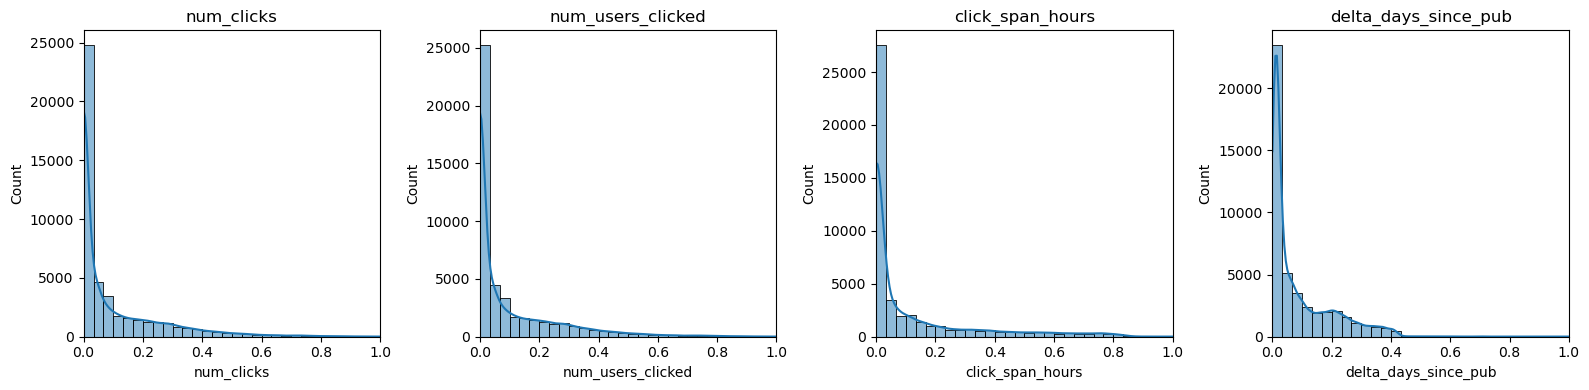

In [51]:
# V√©rification de la variance
plot_feature_distributions(
    article_clicks_features,
    feature_columns=["num_clicks", "num_users_clicked", "click_span_hours", "delta_days_since_pub"]
)


#### üìå 3: Embeddings

In [52]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# 1. Charger les embeddings (index = article_id)
embeddings_df = pd.read_parquet("./data/articles_embeddings_pca.parquet")
embeddings_df.index.name = "article_id"

# 2. Garder uniquement les articles cliqu√©s
embeddings_filtered = embeddings_df.loc[embeddings_df.index.intersection(clicked_article_ids)]

# 3. V√©rifier les valeurs (min/max) pour d√©cider de la normalisation
print("Min:", embeddings_filtered.min().min(), "Max:", embeddings_filtered.max().max())

# 4. Normalisation si n√©cessaire (par colonne)
scaler = MinMaxScaler()
embeddings_normalized = pd.DataFrame(
    scaler.fit_transform(embeddings_filtered),
    index=embeddings_filtered.index,
    columns=embeddings_filtered.columns
)

embeddings_normalized

Min: -22.667787551879883 Max: 20.652034759521484


0         1         2         3         4         5   \
article_id                                                               
3           0.338502  0.781313  0.178670  0.645552  0.648202  0.396773   
27          0.233939  0.453415  0.279923  0.677090  0.581332  0.603472   
69          0.306419  0.715136  0.358801  0.445108  0.593920  0.379970   
81          0.251242  0.688924  0.260744  0.637864  0.592283  0.472482   
84          0.112736  0.646962  0.368792  0.498718  0.581802  0.405507   
...              ...       ...       ...       ...       ...       ...   
364017      0.604784  0.611850  0.377301  0.661967  0.392525  0.683066   
364022      0.419011  0.792951  0.370740  0.545155  0.616214  0.758736   
364028      0.543778  0.833372  0.263209  0.504064  0.429761  0.361478   
364043      0.403265  0.582130  0.628788  0.591323  0.000000  0.624426   
364046      0.427475  0.625977  0.648836  0.644086  0.001343  0.639510   

                  6         7         8         9   ...        31        32  \
article_id                                          ...                       
3           0.482124  0.288584  0.586785  0.775073  ...  0.513373  0.415849   
27          0.402781  0.304126  0.437974  0.827413  ...  0.460132  0.333359   
69          0.422582  0.380719  0.354350  0.631077  ...  0.326871  0.261393   
81          0.416699  0.398406  0.357115  0.709954  ...  0.420788  0.339843   
84          0.327446  0.330366  0.415830  0.676578  ...  0.297965  0.358423   
...              ...       ...       ...       ...  ...       ...       ...   
364017      0.389788  0.501751  0.367658  0.536619  ...  0.556957  0.371015   
364022      0.307420  0.366321  0.415869  0.536285  ...  0.373224  0.503626   
364028      0.476600  0.467516  0.536725  0.453019  ...  0.639735  0.526516   
364043      0.490908  0.536378  0.494796  0.642415  ...  0.541219  0.512922   
364046      0.410766  0.472979  0.547595  0.702206  ...  0.551173  0.511440   

                  33        34        35        36        37        38  \
article_id                                                               
3           0.450855  0.637513  0.664632  0.339570  0.322270  0.401168   
27          0.546271  0.407001  0.573745  0.235091  0.513336  0.519278   
69          0.493929  0.689789  0.552606  0.310475  0.612973  0.567309   
81          0.543833  0.558554  0.500629  0.389851  0.467755  0.644168   
84          0.511341  0.630716  0.454144  0.432006  0.347233  0.473326   
...              ...       ...       ...       ...       ...       ...   
364017      0.547664  0.463625  0.690320  0.542784  0.598484  0.464618   
364022      0.465564  0.272404  0.460719  0.429600  0.552849  0.407583   
364028      0.474469  0.555761  0.294170  0.595951  0.565906  0.438273   
364043      0.559284  0.512749  0.375271  0.402815  0.615266  0.427236   
364046      0.527280  0.489257  0.417667  0.441989  0.509062  0.464491   

                  39        40  
article_id                      
3           0.527650  0.328401  
27          0.426018  0.527091  
69          0.369407  0.332710  
81          0.478085  0.427997  
84          0.358407  0.361635  
...              ...       ...  
364017      0.424030  0.506296  
364022      0.338115  0.288294  
364028      0.554021  0.364353  
364043      0.562657  0.399384  
364046      0.488637  0.395914  

[46033 rows x 41 columns]

### Assemblage du dataframe des features article

In [53]:
articles_merged = words_count_normalized.merge(
    article_clicks_features, on="article_id"
).merge(
    embeddings_normalized, left_on="article_id", right_index=True
)

In [54]:
articles_merged

article_id  words_count  num_clicks  num_users_clicked  \
0               3     0.617858    0.000000           0.000000   
1              27     0.570343    0.000000           0.000000   
2              69     0.644072    0.000000           0.000000   
3              81     0.603190    0.041242           0.041606   
4              84     0.575455    0.000000           0.000000   
...           ...          ...         ...                ...   
46028      364017     0.611802    0.248426           0.241284   
46029      364022     0.648285    0.000000           0.000000   
46030      364028     0.641707    0.000000           0.000000   
46031      364043     0.697039    0.152989           0.154339   
46032      364046     0.700888    0.041242           0.041606   

       click_span_hours  delta_days_since_pub         0         1         2  \
0              0.000000              0.297006  0.338502  0.781313  0.178670   
1              0.000000              0.092576  0.233939  0.453415  0.279923   
2              0.000000              0.413080  0.306419  0.715136  0.358801   
3              0.012364              0.403983  0.251242  0.688924  0.260744   
4              0.000000              0.403508  0.112736  0.646962  0.368792   
...                 ...                   ...       ...       ...       ...   
46028          0.779026              0.063214  0.604784  0.611850  0.377301   
46029          0.000000              0.597569  0.419011  0.792951  0.370740   
46030          0.000000              0.408264  0.543778  0.833372  0.263209   
46031          0.589568              0.222374  0.403265  0.582130  0.628788   
46032          0.583069              0.014109  0.427475  0.625977  0.648836   

              3  ...        31        32        33        34        35  \
0      0.645552  ...  0.513373  0.415849  0.450855  0.637513  0.664632   
1      0.677090  ...  0.460132  0.333359  0.546271  0.407001  0.573745   
2      0.445108  ...  0.326871  0.261393  0.493929  0.689789  0.552606   
3      0.637864  ...  0.420788  0.339843  0.543833  0.558554  0.500629   
4      0.498718  ...  0.297965  0.358423  0.511341  0.630716  0.454144   
...         ...  ...       ...       ...       ...       ...       ...   
46028  0.661967  ...  0.556957  0.371015  0.547664  0.463625  0.690320   
46029  0.545155  ...  0.373224  0.503626  0.465564  0.272404  0.460719   
46030  0.504064  ...  0.639735  0.526516  0.474469  0.555761  0.294170   
46031  0.591323  ...  0.541219  0.512922  0.559284  0.512749  0.375271   
46032  0.644086  ...  0.551173  0.511440  0.527280  0.489257  0.417667   

             36        37        38        39        40  
0      0.339570  0.322270  0.401168  0.527650  0.328401  
1      0.235091  0.513336  0.519278  0.426018  0.527091  
2      0.310475  0.612973  0.567309  0.369407  0.332710  
3      0.389851  0.467755  0.644168  0.478085  0.427997  
4      0.432006  0.347233  0.473326  0.358407  0.361635  
...         ...       ...       ...       ...       ...  
46028  0.542784  0.598484  0.464618  0.424030  0.506296  
46029  0.429600  0.552849  0.407583  0.338115  0.288294  
46030  0.595951  0.565906  0.438273  0.554021  0.364353  
46031  0.402815  0.615266  0.427236  0.562657  0.399384  
46032  0.441989  0.509062  0.464491  0.488637  0.395914  

[46033 rows x 47 columns]

In [55]:
# V√©rification rapide :
print("Dimensions apr√®s fusion :", articles_merged.shape)
print("Nombre de NaN dans embeddings :")
print(articles_merged.iloc[:, -embeddings_df.shape[1]:].isna().sum().sum())  # colonne embeddings uniquement

Dimensions apr√®s fusion : (46033, 47)
Nombre de NaN dans embeddings :
0


### Re-ordonnancement des articles pour correspondre aux idx (de la matrice user-item)

In [56]:
# 1. Ajouter item_idx √† merged_df
articles_merged["item_idx"] = articles_merged["article_id"].map(item_mapping)

# 2. Supprimer les articles qui n'existent pas dans le mapping (juste par s√©curit√©)
articles_merged = articles_merged.dropna(subset=["item_idx"])
articles_merged["item_idx"] = articles_merged["item_idx"].astype(int)

# 3. R√©ordonner par item_idx
articles_merged = articles_merged.sort_values("item_idx")

### Construction de la matrice sparse

üöß LightFM ne connait que les articles de la matrice d'interaction, donc tous les non-cliqu√©s sont absents.

In [57]:
# 4. Construire la matrice CSR finale
item_features_matrix = csr_matrix(articles_merged.drop(columns=["article_id", "item_idx"]).values)

# 5. V√©rification
print("‚úÖ Matrice finale :", item_features_matrix.shape)

‚úÖ Matrice finale : (46033, 46)


### Entrainement et √©valuation du mod√®le hybride avec user features + items features

### V√©rification de la matrice d'interactions

In [58]:
print("user_features_matrix shape:", user_features_matrix.shape)
print("item_features_matrix shape:", item_features_matrix.shape if 'item_features_matrix' in locals() else "Not defined")


user_features_matrix shape: (322897, 24)
item_features_matrix shape: (46033, 46)


In [59]:
print("train_matrix shape:", train_matrix_hybrid.shape)
print("Nombre total d'interactions :", train_matrix_hybrid.nnz)
print("Valeurs uniques dans train_matrix :", np.unique(train_matrix_hybrid.data))


train_matrix shape: (322897, 46033)
Nombre total d'interactions : 31932
Valeurs uniques dans train_matrix : [0.1431114  0.18453512 0.18946382 0.20836785 0.23784459 0.24465054
 0.25192964 0.2695773  0.29248124 0.31546488 0.32365668 0.32389054
 0.36907023 0.38776192 0.41702187 0.43067655 0.44250706 0.4608454
 0.5        0.51335436 0.5532948  0.564575   0.5693234  0.5849625
 0.60170126 0.60920453 0.63092977 0.6437928  0.6477811  0.6609641
 0.6826062  0.70281816 0.7124144  0.73042274 0.73141587 0.7324868
 0.7520505  0.7564708  0.7729429  0.7758643  0.79248124 0.813196
 0.83291125 0.83404374 0.87695146 0.88562185 0.90367746 0.9216908
 0.961916   0.96739626 0.9786022  1.        ]


### V√©rification des matrices user et item features

In [60]:
print("User features - min/max:", user_features_matrix.min(), user_features_matrix.max())
print("Item features - min/max:", item_features_matrix.min(), item_features_matrix.max())


User features - min/max: 0.0 1.0000000000000002
Item features - min/max: 0.0 1.0000001192092896


In [61]:
import numpy as np

print("User features - min/max:",
      user_features_matrix.min(), user_features_matrix.max())
print("Item features - min/max:",
      item_features_matrix.min(), item_features_matrix.max())

# Convert to dense for mean/std
user_dense = user_features_matrix.toarray()
item_dense = item_features_matrix.toarray()

print("User features - mean/std:",
      np.mean(user_dense), np.std(user_dense))
print("Item features - mean/std:",
      np.mean(item_dense), np.std(item_dense))


User features - min/max: 0.0 1.0000000000000002
Item features - min/max: 0.0 1.0000001192092896
User features - mean/std: 0.18283405276186812 0.37095055517201053
Item features - mean/std: 0.4642401458376035 0.1776323995043909


In [62]:
print(user_features_matrix[:5].toarray())
print(item_features_matrix[:5].toarray())


[[0.19728975 0.18253639 0.18757316 0.         0.         0.
  0.         1.         0.         0.         0.         0.
  0.         0.         0.         1.         0.         0.
  1.         0.         0.         0.         0.         1.        ]
 [0.26973676 0.24363452 0.25035718 0.         1.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         1.         1.
  0.         0.         0.         0.         0.         1.        ]
 [0.08730211 0.08487459 0.08721655 0.         0.         0.
  0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.         1.         1.
  0.         0.         0.         0.         0.         1.        ]
 [0.26973676 0.29770403 0.30591864 0.         0.         0.
  0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.         1.         0.
  1.         0.         0.         0.         0.         1.        ]
 [0.

In [63]:
best_model, best_params, best_score = grid_search_lightfm(
    train_matrix_hybrid,
    test_matrix_hybrid,
    user_features=user_features_matrix,
    item_features=item_features_matrix,
    k=5,
    max_epochs=30,
    eval_metric="ndcg",
    eval_every=5,
    patience=3
)

üîç Recherche sur 12 combinaisons...

üöÄ Entra√Ænement mod√®le : loss=warp, components=32, lr=0.01
üìâ Epoch 5 ‚Äî ndcg@5 = 0.1521
üìâ Epoch 10 ‚Äî ndcg@5 = 0.1506
üìâ Epoch 15 ‚Äî ndcg@5 = 0.1506
üìâ Epoch 20 ‚Äî ndcg@5 = 0.1506
üõë Early stopping √† l‚Äôepoch 20 (aucune am√©lioration depuis 3 √©valuations)

üöÄ Entra√Ænement mod√®le : loss=warp, components=32, lr=0.05
üìâ Epoch 5 ‚Äî ndcg@5 = 0.1452
üìâ Epoch 10 ‚Äî ndcg@5 = 0.1332
üìâ Epoch 15 ‚Äî ndcg@5 = 0.1475
üìâ Epoch 20 ‚Äî ndcg@5 = 0.1420
üìâ Epoch 25 ‚Äî ndcg@5 = 0.1521
üìâ Epoch 30 ‚Äî ndcg@5 = 0.1514

üöÄ Entra√Ænement mod√®le : loss=warp, components=32, lr=0.1
üìâ Epoch 5 ‚Äî ndcg@5 = 0.1459
üìâ Epoch 10 ‚Äî ndcg@5 = 0.1421
üìâ Epoch 15 ‚Äî ndcg@5 = 0.1379
üìâ Epoch 20 ‚Äî ndcg@5 = 0.1367
üõë Early stopping √† l‚Äôepoch 20 (aucune am√©lioration depuis 3 √©valuations)

üöÄ Entra√Ænement mod√®le : loss=warp, components=64, lr=0.01
üìâ Epoch 5 ‚Äî ndcg@5 = 0.1506
üìâ Epoch 10 ‚Äî ndcg@5 = 0.1488
üìâ 

In [68]:
model_hybrid_user_item = train_lightfm_model(train_matrix, best_params,
                                        user_features=user_features_matrix,
                                        item_features=item_features_matrix,
                                        epochs=50, num_threads=8
                                       )

Entra√Ænement LightFM:   0%|          | 0/50 [00:00<?, ?it/s]

In [69]:
results = evaluate_lightfm_model(model_hybrid_user_item, train_matrix, test_matrix,
                                 user_features=user_features_matrix, item_features=item_features_matrix,
                                 experiment_name="user-item_raw + user features + item features")
print(results)

Shape pass√©e √† ndcg_at_k: (322897, 46033)


Calcul NDCG@k (parall√®le):   0%|          | 0/322897 [00:00<?, ?it/s]

Calcul RMSE/MAE (parall√®le):   0%|          | 0/322897 [00:00<?, ?it/s]

üìÑ R√©sultats mis √† jour dans results/experiments_lightfm.csv
{'Experiment': 'user-item_raw + user features + item features', 'Hit@5': 0.000910507, 'Recall@5': 0.004552535328603239, 'NDCG@5': 0.002624711114518163, 'RMSE': 3353.6026039980056, 'MAE': 3330.7037079446513}


In [70]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_experiments_results(results_file="results/experiments_lightfm.csv"):
    """
    Charge le fichier CSV des r√©sultats LightFM, 
    et trace un barplot comparatif des principales m√©triques.
    """

    # 1. Charger le CSV
    results_df = pd.read_csv(results_file)
    print(f"‚úÖ Charg√© : {results_df.shape[0]} exp√©riences.")

    # 2. Afficher le DataFrame brut
    print(results_df)

    # 3. Choisir les m√©triques √† tracer
    metrics_to_plot = ['Hit@5', 'Recall@5', 'NDCG@5']

    # 4. Tracer un barplot par m√©trique
    for metric in metrics_to_plot:
        plt.figure(figsize=(8, 5))
        plt.barh(results_df['Experiment'], results_df[metric], color='skyblue')
        plt.xlabel(metric)
        plt.title(f'Comparaison des exp√©riences - {metric}')
        plt.grid(True, axis='x')
        plt.show()

    return results_df


‚úÖ Charg√© : 9 exp√©riences.
                                      Experiment     Hit@5  Recall@5  \
0                                      user-item  0.036429  0.182145   
1                               user-minmax_item  0.008486  0.042431   
2                      user-item + user features  0.001261  0.006307   
3      user-item + user features + item features  0.005390  0.026950   
4                                      user-item  0.036471  0.182355   
5                               user-minmax_item  0.008372  0.041858   
6                      user-item + user features  0.000688  0.003440   
7      user-item + user features + item features  0.004931  0.024656   
8  user-item_raw + user features + item features  0.000911  0.004553   

     NDCG@5         RMSE          MAE  
0  0.129126     2.469346     1.931845  
1  0.032088     2.013459     1.553353  
2  0.003406   323.790686   318.816688  
3  0.021767   396.710702   391.265317  
4  0.129338     2.470857     1.932961  
5  0.0314

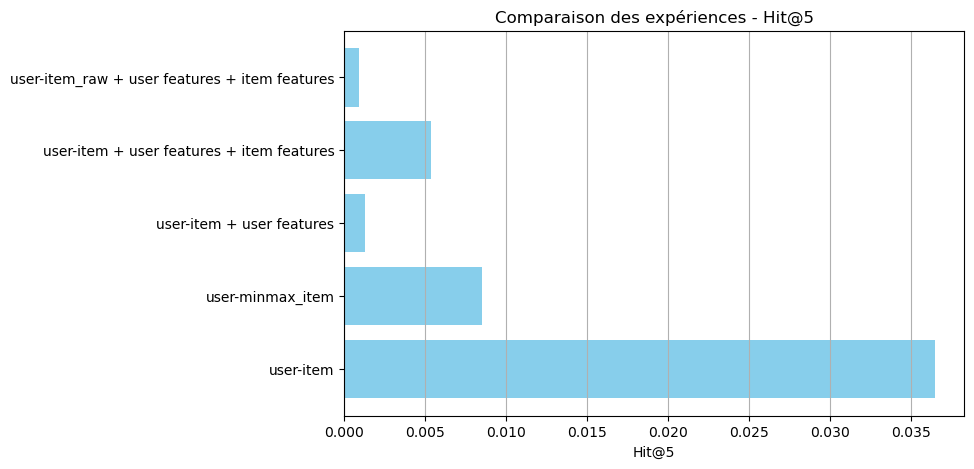

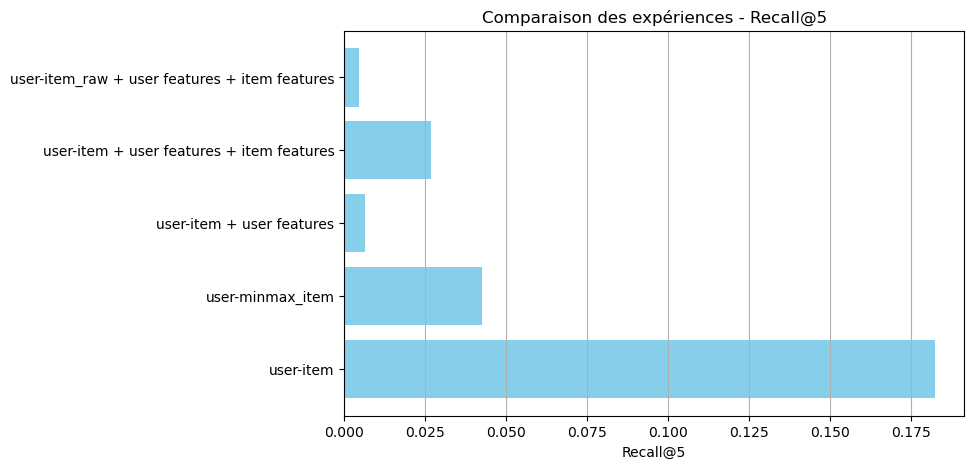

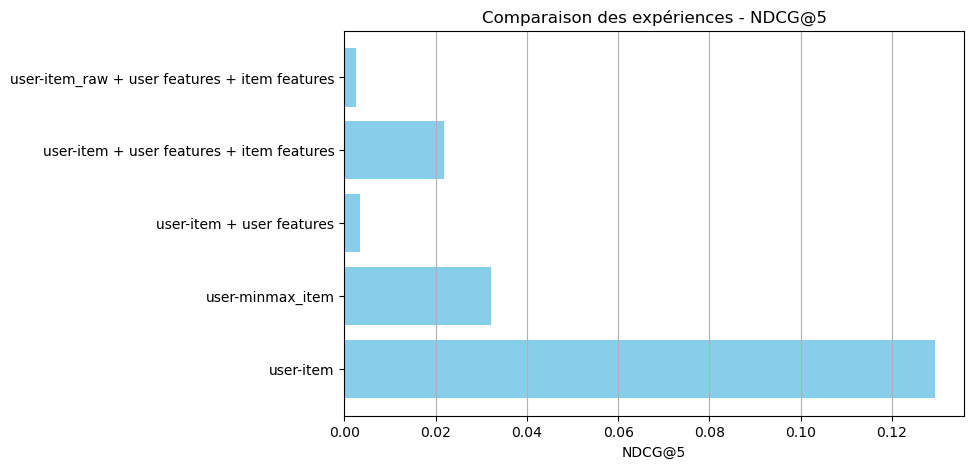

In [71]:
results_df = plot_experiments_results()